# == import ==

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint

In [6]:
# Load the CSV file
csv_path = "../dataset/training.csv"
data = pd.read_csv(csv_path)

In [7]:
# Fill missing values
data.fillna(data.mean(), inplace=True)

# Normalize landmark coordinates (assuming images are 96x96)
for col in data.columns:
    if "_x" in col or "_y" in col:
        data[col] /= 96.0

 # === 2. Split the Data === 

In [8]:
# Assuming 'image' column contains image paths
image_folder = "../dataset/images/train_images"  # Folder containing training images
image_paths = [os.path.join(image_folder, f"{i}.jpg") for i in data.index]
landmarks = data.drop(columns=[]).values  # Exclude image column if it exists


In [9]:
# Split dataset
train_images, val_images, train_landmarks, val_landmarks = train_test_split(
    image_paths, landmarks, test_size=0.2, random_state=42
)


# === 3. Preprocess Images ===

In [10]:
# === 3. Preprocess Images ===
def load_image(img_path):
    """Load and preprocess an image."""
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if image is None:  # Handle missing files
        return np.zeros((96, 96))  # Placeholder for missing images
    image = cv2.resize(image, (96, 96))
    return image / 255.0  # Normalize to [0, 1]

In [11]:
# Load all images
train_images = np.array([load_image(img) for img in train_images])
val_images = np.array([load_image(img) for img in val_images])

In [12]:
# Add channel dimension (for grayscale images)
train_images = train_images[..., np.newaxis]
val_images = val_images[..., np.newaxis]

# === 4. Build the Model ===

In [13]:
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(96, 96, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(30)  # Output layer for 30 landmarks
])

In [14]:
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# === 5. Train the Model ===

In [15]:
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss", mode="min")
history = model.fit(
    train_images, train_landmarks,
    validation_data=(val_images, val_landmarks),
    epochs=20,
    batch_size=32,
    callbacks=[checkpoint]
)

Epoch 1/20
177/177 [==============================] - 76s 421ms/step - loss: 0.0111 - mae: 0.0507 - val_loss: 9.0837e-04 - val_mae: 0.0193
Epoch 2/20


c:\Users\daksh\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


177/177 [==============================] - 68s 386ms/step - loss: 8.4377e-04 - mae: 0.0190 - val_loss: 7.2382e-04 - val_mae: 0.0169
Epoch 3/20
177/177 [==============================] - 69s 390ms/step - loss: 6.9614e-04 - mae: 0.0170 - val_loss: 6.3384e-04 - val_mae: 0.0155
Epoch 4/20
177/177 [==============================] - 69s 389ms/step - loss: 6.6966e-04 - mae: 0.0172 - val_loss: 6.2669e-04 - val_mae: 0.0156
Epoch 5/20
177/177 [==============================] - 71s 402ms/step - loss: 5.6335e-04 - mae: 0.0155 - val_loss: 5.8253e-04 - val_mae: 0.0150
Epoch 6/20
177/177 [==============================] - 70s 397ms/step - loss: 5.6878e-04 - mae: 0.0158 - val_loss: 8.8733e-04 - val_mae: 0.0218
Epoch 7/20
177/177 [==============================] - 72s 405ms/step - loss: 5.1945e-04 - mae: 0.0153 - val_loss: 6.0145e-04 - val_mae: 0.0158
Epoch 8/20
177/177 [==============================] - 69s 389ms/step - loss: 4.6444e-04 - mae: 0.0144 - val_loss: 5.7002e-04 - val_mae: 0.0149
Epoch 9/20

# === 6. Evaluate and Test ===

In [18]:
# Test on a single image
test_image_path = "../dataset/images/test_images/0.jpg"  # Replace with a valid test image path
test_image = load_image(test_image_path)
test_image_input = test_image[np.newaxis, ..., np.newaxis]  # Add batch and channel dimensions
predicted_landmarks = model.predict(test_image_input)

1/1 [==============================] - 0s 40ms/step


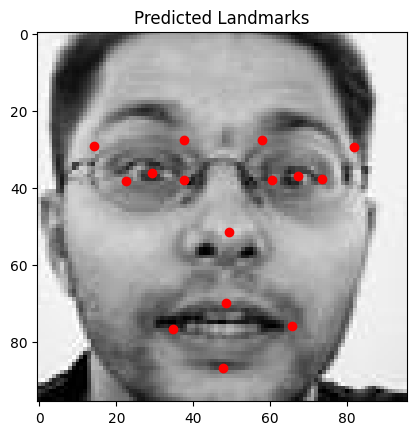

In [19]:
# Plot the image with predicted landmarks
plt.imshow(test_image, cmap="gray")
for i in range(0, len(predicted_landmarks[0]), 2):
    x, y = predicted_landmarks[0][i] * 96, predicted_landmarks[0][i + 1] * 96
    plt.scatter(x, y, color="red")
plt.title("Predicted Landmarks")
plt.show()

# === 7. Save the Model and Results ===


In [20]:

model.save("facial_landmark_model.h5")
print("Model training complete and saved!")

Model training complete and saved!


c:\Users\daksh\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


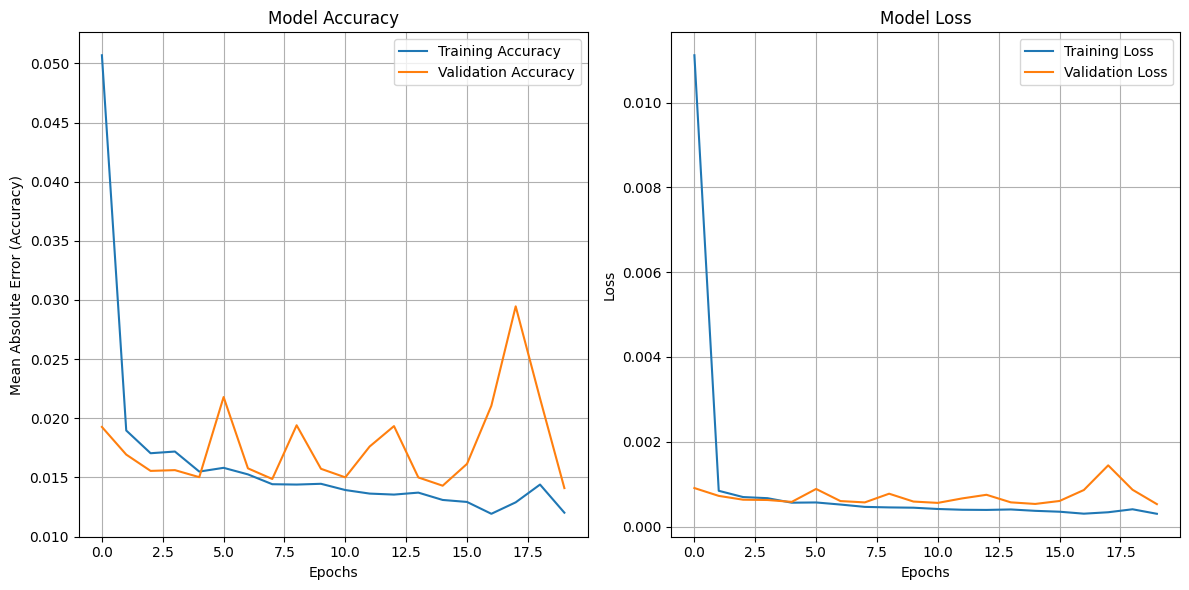

In [22]:
import matplotlib.pyplot as plt

# === Plot Accuracy and Loss ===
def plot_metrics(history):
    """Plot training and validation accuracy and loss over epochs."""
    
    # Plot accuracy
    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['mae'], label='Training Accuracy')
    plt.plot(history.history['val_mae'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error (Accuracy)')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the function to plot accuracy and loss
plot_metrics(history)
